# Visualising Species Distribution

This is an example of how coresets can be used to generate the species distribution visualisation from [scikit-learn](https://scikit-learn.org/stable/auto_examples/neighbors/plot_species_kde.html#sphx-glr-auto-examples-neighbors-plot-species-kde-py).
Much of this code has been lifted from the relevant sklearn page and then adapted for use with a coreset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_species_distributions
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import KernelDensity
from datasketches import density_sketch
%matplotlib inline
# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap

    basemap = True
except ImportError:
    basemap = False

In [2]:
def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)

In [4]:
# Get matrices/arrays of species IDs and locations
# if fetch_species_distributions() call does not work you may need 
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

data = fetch_species_distributions()
species_names = ["Bradypus Variegatus", "Microryzomys Minutus"]

Xtrain = np.vstack([data["train"]["dd lat"], data["train"]["dd long"]]).T
ytrain = np.array(
    [d.decode("ascii").startswith("micro") for d in data["train"]["species"]],
    dtype="int",
)
Xtrain *= np.pi / 180.0  # Convert lat/long to radians

In [5]:
# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = xy[land_mask]
xy *= np.pi / 180.0

 - computing KDE in spherical coordinates
 - plot coastlines from coverage
 - computing KDE in spherical coordinates
 - plot coastlines from coverage


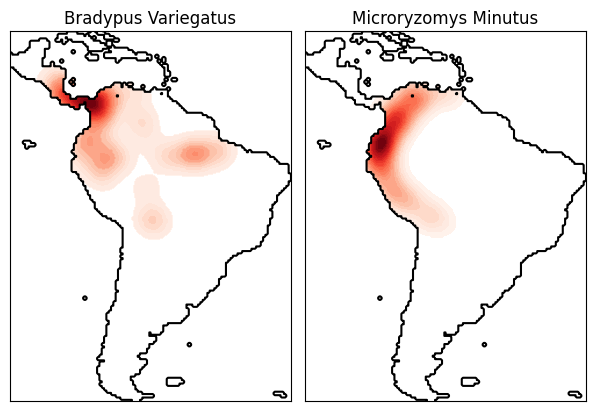

In [6]:
# Plot map of South America with distributions of each species
fig = plt.figure()
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution
    print(" - computing KDE in spherical coordinates")
    kde = KernelDensity(
        bandwidth=0.04, metric="haversine", kernel="gaussian", algorithm="ball_tree"
    )
    kde.fit(Xtrain[ytrain == i])

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999, dtype="int")
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

    if basemap:
        print(" - plot coastlines using basemap")
        m = Basemap(
            projection="cyl",
            llcrnrlat=Y.min(),
            urcrnrlat=Y.max(),
            llcrnrlon=X.min(),
            urcrnrlon=X.max(),
            resolution="c",
        )
        m.drawcoastlines()
        m.drawcountries()
    else:
        print(" - plot coastlines from coverage")
        plt.contour(
            X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid"
        )
        plt.xticks([])
        plt.yticks([])

    plt.title(species_names[i])

This method uses the Haversine distance.  We only have implemented the Euclidean distance so will use Euclidean distance for comparisons.

 - computing KDE in spherical coordinates
 - plot coastlines from coverage
 - computing KDE in spherical coordinates
 - plot coastlines from coverage


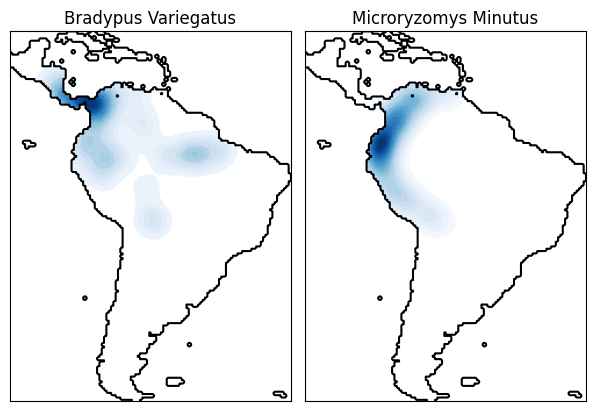

In [7]:
# Plot map of South America with distributions of each species
fig = plt.figure()
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution
    print(" - computing KDE in spherical coordinates")
    kde = KernelDensity(
        bandwidth=0.04, metric="euclidean", kernel="gaussian", algorithm="ball_tree"
    )
    kde.fit(Xtrain[ytrain == i])

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999, dtype="int")
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Blues)

    if basemap:
        print(" - plot coastlines using basemap")
        m = Basemap(
            projection="cyl",
            llcrnrlat=Y.min(),
            urcrnrlat=Y.max(),
            llcrnrlon=X.min(),
            urcrnrlon=X.max(),
            resolution="c",
        )
        m.drawcoastlines()
        m.drawcountries()
    else:
        print(" - plot coastlines from coverage")
        plt.contour(
            X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid"
        )
        plt.xticks([])
        plt.yticks([])

    plt.title(species_names[i])

Now we will define our own kernel function so that we can check the density sketch properly.  The scikit-learn implementation uses a kernel defined as:
\begin{align}
\hat{f}(x^*) = \frac{1}{2 \pi^{d/2} h^d} \cdot \frac1n \sum_{i=1}^n K\left( -\frac{||x^* - x_i ||^2}{2 h^2} \right).
\end{align}

However, they actually use a tree-based implementation so that points far away from the test points are grouped by leaf to give a common contribution to the sum which reduces the total number of evaluations in the summation.
Unlike the tree-based implementation, this coreset implementation evaluates the full sum over the retained points.

In [8]:
def kernel_density(Xtrain, Xtest, bandwidth=1.):
    """
    Returns the kernel density estimate between Xtrain and Xtest.
    returns:
        (1/n)*(1/bandwidth*sqrt(2pi))\sum_{i=1}^n K( (x* - x_i) / bandwidth )
    The bandwidth in scipy is in the numerator so we use 1./bandwidth
    The mean function picks up the 1/n factor.
    """
    for x in [Xtrain, Xtest]:
        if x.ndim == 1:
            x.reshape(-1, 1)
    assert Xtrain.shape[1] == Xtest.shape[1] 
    d = Xtest.shape[1]
    g = (1./bandwidth)**2
    K = rbf_kernel(Xtrain, Xtest, gamma=0.5*g)
    K /= (bandwidth*np.sqrt(2.*np.pi))**d
    return np.mean(K, axis=0)

 - computing KDE in spherical coordinates
 - plot coastlines from coverage
 - computing KDE in spherical coordinates
 - plot coastlines from coverage


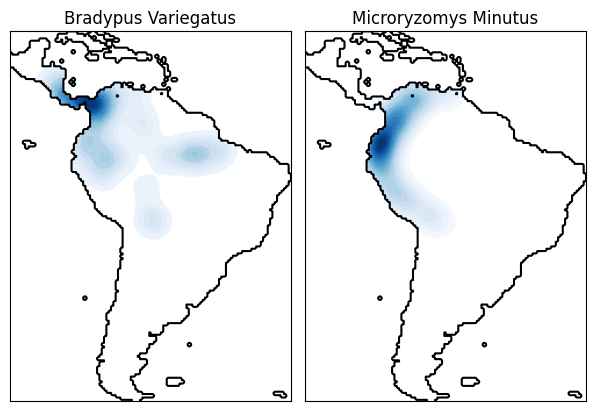

In [9]:
# Plot map of South America with distributions of each species
fig = plt.figure()
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution
    print(" - computing KDE in spherical coordinates")
    kde = KernelDensity(
        bandwidth=0.04, metric="euclidean", kernel="gaussian", algorithm="ball_tree"
    )
    kde.fit(Xtrain[ytrain == i])
    
    my_kde = kernel_density(Xtrain[ytrain == i], xy, bandwidth=0.04)

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999, dtype="int")
    Z[land_mask] = my_kde 
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Blues)

    if basemap:
        print(" - plot coastlines using basemap")
        m = Basemap(
            projection="cyl",
            llcrnrlat=Y.min(),
            urcrnrlat=Y.max(),
            llcrnrlon=X.min(),
            urcrnrlon=X.max(),
            resolution="c",
        )
        m.drawcoastlines()
        m.drawcountries()
    else:
        print(" - plot coastlines from coverage")
        plt.contour(
            X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid"
        )
        plt.xticks([])
        plt.yticks([])

    plt.title(species_names[i])

This looks almost identical to the sklearn implementation.  Now let's use a coreset and compare the two.

In [10]:
class CoresetKDE:
    def __init__(self, k_, dim_, bandwidth_=1):
        self.k = k_
        self.dim = dim_
        self.bandwidth = bandwidth_
        self.normalisation_factor = np.sqrt(2.)*self.bandwidth
        self.estimation_scale_factor = 1./(self.bandwidth*np.sqrt(2.*np.pi))**self.dim
        self.sketch = density_sketch(self.k,  self.dim)
    
    def fit(self, X_):
        """Fits the coreset to the data"""
        for x_ in X_:
            self.sketch.update(x_ / self.normalisation_factor)
            
    def predict(self, X):
        """Returns density estimates over array X"""
        predictions = np.zeros((len(X)), dtype=X.dtype)
        for i, x in enumerate(X):
            predictions[i] = self.estimation_scale_factor*self.sketch.get_estimate( x / self.normalisation_factor)
        return predictions
    
    def get_coreset(self):
        """Returns the weighted coreset"""
        samples_weights = [pw for pw in self.sketch]
        samples = np.zeros((self.sketch.get_num_retained(), self.dim))
        weights = np.zeros((self.sketch.get_num_retained(),))
        for i, pw in enumerate(self.sketch):
            samples[i] = pw[0]
            weights[i] = pw[1]
        return samples*self.normalisation_factor, weights

Coreset size: 81 of 926
 - plot coastlines from coverage
Coreset size: 90 of 698
 - plot coastlines from coverage


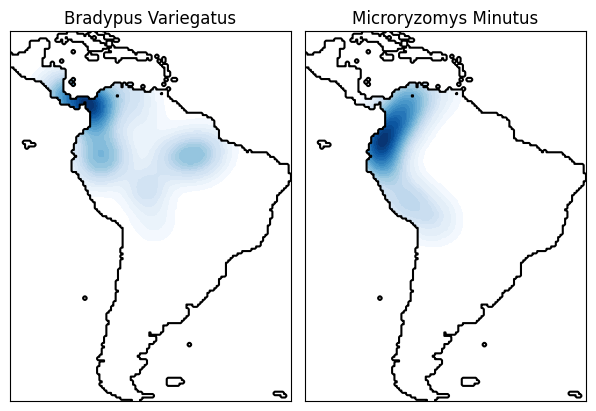

In [11]:
# Plot map of South America with distributions of each species
fig = plt.figure()
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution using the coreset.
    c = CoresetKDE(16, 2, bandwidth_=0.04)
    c.fit(Xtrain[ytrain==i])
    c_ests = c.predict(xy)
    print(f"Coreset size: {c.sketch.get_num_retained()} of {c.sketch.get_n()}")
    #coreset_points, coreset_weights = c.get_coreset()
    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999, dtype="int")
    Z[land_mask] = c_ests 
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Blues)

    if basemap:
        print(" - plot coastlines using basemap")
        m = Basemap(
            projection="cyl",
            llcrnrlat=Y.min(),
            urcrnrlat=Y.max(),
            llcrnrlon=X.min(),
            urcrnrlon=X.max(),
            resolution="c",
        )
        m.drawcoastlines()
        m.drawcountries()
    else:
        print(" - plot coastlines from coverage")
        plt.contour(
            X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid"
        )
        plt.xticks([])
        plt.yticks([])

    plt.title(species_names[i])

The coreset is very similar to the brute force approach but is evaluated over many fewer points.